## Main file, will be copied to neuralnet.py

In [ ]:
import numpy as np
import pickle
from tqdm import tqdm_notebook as tqdm

config = {}
config['layer_specs'] = [784, 50, 10]  # The length of list denotes number of hidden layers; each element denotes number of neurons in that layer; first element is the size of input layer, last element is the size of output layer.
config['activation'] = 'tanh' # Takes values 'sigmoid', 'tanh' or 'ReLU'; denotes activation function for hidden layers
config['batch_size'] = 500  # Number of training samples per batch to be passed to network
config['epochs'] = 50  # Number of epochs to train the model
config['early_stop'] = True  # Implement early stopping or not
config['early_stop_epoch'] = 5  # Number of epochs for which validation loss increases to be counted as overfitting
config['L2_penalty'] = 0  # Regularization constant
config['momentum'] = True  # Denotes if momentum is to be applied or not
config['momentum_gamma'] = 0.9  # Denotes the constant 'gamma' in momentum expression
config['learning_rate'] = 0.0007 # Learning rate of gradient descent algorithm

def softmax(x):
  """
  Write the code for softmax activation function that takes in a numpy array and returns a numpy array.
  """
  out_exp = np.exp(x)
  sum_out_exp = out_exp.sum(axis=1)  
  output = out_exp/sum_out_exp[:,None]  
  return output

def sigmoid(x):
  """
  General Sigmoid function
  """
  return 1./(1. + np.exp(-x))

def load_data(fname):
  """
  Write code to read the data and return it as 2 numpy arrays.
  Make sure to convert labels to one hot encoded format.
  """
  f = open(fname, 'rb')
  data = pickle.load(f)
  f.close()
  images, labels = data[:, :-1], data[:, -1]

  labels = labels.astype(np.int)
  onehotlabels = np.zeros((len(labels), labels.max()+1))
  onehotlabels[np.arange(len(labels)), labels] = 1
  return images, onehotlabels


class Activation:
  def __init__(self, activation_type = "sigmoid"):
    self.activation_type = activation_type
    self.x = None # Save the input 'x' for sigmoid or tanh or ReLU to this variable since it will be used later for computing gradients.
  
  def forward_pass(self, a):
    if self.activation_type == "sigmoid":
      return self.sigmoid(a)
    
    elif self.activation_type == "tanh":
      return self.tanh(a)
    
    elif self.activation_type == "ReLU":
      return self.ReLU(a)
  
  def backward_pass(self, delta):
    if self.activation_type == "sigmoid":
      grad = self.grad_sigmoid()
    
    elif self.activation_type == "tanh":
      grad = self.grad_tanh()
    
    elif self.activation_type == "ReLU":
      grad = self.grad_ReLU()
    
    return grad * delta
      
  def sigmoid(self, x):
    """
    Write the code for sigmoid activation function that takes in a numpy array and returns a numpy array.
    """
    self.x = x
    output = sigmoid(x)
    return output

  def tanh(self, x):
    """
    Write the code for tanh activation function that takes in a numpy array and returns a numpy array.
    """
    self.x = x
    output = np.tanh(x)
    return output

  def ReLU(self, x):
    """
    Write the code for ReLU activation function that takes in a numpy array and returns a numpy array.
    """
    self.x = x
    output = np.maximum(x, 0)
    return output

  def grad_sigmoid(self):
    """
    Write the code for gradient through sigmoid activation function that takes in a numpy array and returns a numpy array.
    """
    sigmoid_x = sigmoid(self.x)
    grad = sigmoid_x * (1-sigmoid_x)
    return grad

  def grad_tanh(self):
    """
    Write the code for gradient through tanh activation function that takes in a numpy array and returns a numpy array.
    """
    tanh_x = np.tanh(self.x)
    grad = 1 - (tanh_x * tanh_x)
    return grad

  def grad_ReLU(self):
    """
    Write the code for gradient through ReLU activation function that takes in a numpy array and returns a numpy array.
    """
    grad = np.where(self.x <= 0, 0, 1)
    return grad


class Layer():
  def __init__(self, in_units, out_units):
    np.random.seed(42)
    self.w = np.random.randn(in_units, out_units)  # Weight matrix
    self.b = np.zeros((1, out_units)).astype(np.float32)  # Bias
    self.x = None  # Save the input to forward_pass in this
    self.a = None  # Save the output of forward pass in this (without activation)
    self.d_x = None  # Save the gradient w.r.t x in this (AKA Delta to pass to previous layer = dE/dx)
    self.d_w = None  # Save the gradient w.r.t w in this (AKA dE/dw = Delta received . dx/dw)
    self.d_b = None  # Save the gradient w.r.t b in this (AKA dE/db = Delta received . 1)

  def forward_pass(self, x):
    """
    Write the code for forward pass through a layer. Do not apply activation function here.
    """
    self.x = x
    self.a = x @ self.w + self.b
    return self.a
  
  def backward_pass(self, delta):
    """
    Write the code for backward pass. This takes in gradient from its next layer as input,
    computes gradient for its weights and the delta to pass to its previous layers.
    """

    # This is dE/dw = delta received . dx/dw
    
    def harmadards_sum(X, Y):
      """
        X is [n, dim_x] 
        Y is [n, dim_y]
        Return the sum of all harmadard products between each vector x and y at index i to n
      """
      ans = np.zeros((X.shape[1], Y.shape[1]))
      for i in range(len(X)):
        ans += (X[i][:,None] * Y[i])
      return ans
    
    self.d_w = harmadards_sum(self.x, delta)

    # This is dE/db = delta received . 1
    self.d_b = delta.sum(axis=0)
                
    # This is delta to be passed to previous layer
    self.d_x = delta @ self.w.T
    return self.d_x

      
class Neuralnetwork():
  def __init__(self, config):
    self.layers = []
    self.x = None  # Save the input to forward_pass in this
    self.y = None  # Save the output vector of model in this
    self.targets = None  # Save the targets in forward_pass in this variable
    for i in range(len(config['layer_specs']) - 1):
      self.layers.append( Layer(config['layer_specs'][i], config['layer_specs'][i+1]) )
      
      # Unless it's output unit, add Activation layer on top
      if i < len(config['layer_specs']) - 2:
        self.layers.append(Activation(config['activation']))  
    
  def forward_pass(self, x, targets=None):
    """
    Write the code for forward pass through all layers of the model and return loss and predictions.
    If targets == None, loss should be None. If not, then return the loss computed.
    """
    self.x = x
    self.targets = targets
    
    # Input layer
    out = self.layers[0].forward_pass(x)
    
    # Forward...
    for layer in self.layers[1:]:
      out = layer.forward_pass(out)
      
    # Softmax
    self.y = softmax(out)
        
    # Cross-entropy loss
    if targets is not None:
      return self.loss_func(self.y, targets), self.y
    else:    
      return None, self.y

  def loss_func(self, logits, targets):
    '''
    find cross entropy loss between logits and targets
    '''
    output = -(targets * np.log(logits)).sum()/len(targets)
    return output
    
  def backward_pass(self):
    '''
    implement the backward pass for the whole network. 
    hint - use previously built functions.
    '''
    delta = self.targets - self.y
    
    for layer in reversed(self.layers):
      delta = layer.backward_pass(delta)
    return delta

def trainer(model, X_train, y_train, X_valid, y_valid, config):
  """
  Write the code to train the network. Use values from config to set parameters
  such as L2 penalty, number of epochs, momentum, etc.
  """
  
  BATCH_SIZE = config['batch_size']
  N_EPOCHS = config['epochs']
  LEARNING_RATE = config['learning_rate']
  
  N_BATCHES = len(X_train) // BATCH_SIZE

  EPOCHS_THRESHOLD = config['early_stop_epoch']

  USE_MOMENTUM = config['momentum']
  USE_EARLY_STOP = config['early_stop']
  
  L2_lambda = config['L2_penalty']
  
  GAMMA = 0
  if USE_MOMENTUM:
    GAMMA = config['momentum_gamma']
  
  ACTIVATION = config['activation']
  
  print("-------",
        "Model Config:",
        "\nActivation:", ACTIVATION, 
        "\nN Epoches:", N_EPOCHS, 
        "\nN Batches:",N_BATCHES, 
        "\nBatch size:", BATCH_SIZE, 
        "\nLearning rate:", LEARNING_RATE,
        "\nL2 lambda:", L2_lambda,
        "\nMomentum?", USE_MOMENTUM)
  if USE_MOMENTUM:
    print('Gamma:', GAMMA)

  best_weight_layers = []
  min_loss = float('inf')
  prev_loss = float('inf')
  consecutive_epochs = 0
  
  train_losses = []
  valid_losses = []
  train_accuracies = []
  valid_accuracies = []
  
  for i_epoch in tqdm(range(N_EPOCHS)):
    
    def get_shuffle_inds():
      shuffled_inds = np.arange(len(X_train))
      np.random.shuffle(shuffled_inds)
      return shuffled_inds
    
    shuffled_inds = get_shuffle_inds()        
    
    velocities_w = {l: np.zeros_like(l.w) for l in model.layers if type(l) is Layer}
    velocities_b = {l: np.zeros_like(l.b) for l in model.layers if type(l) is Layer}
    
    for i_minibatch in range(0, len(X_train), BATCH_SIZE):
      inds_batch = shuffled_inds[i_minibatch:i_minibatch + BATCH_SIZE]
      X_batch = X_train[inds_batch]
      y_batch = y_train[inds_batch]
      
      loss, _ = model.forward_pass(X_batch, y_batch)
      delta = model.backward_pass()
            
      # Weight updates
      for l in model.layers:
        if type(l) is Layer:
          
          # To prevent confusion on sign when
          # combining with momentum/regularization
          # ------------------------------------
          
          # l.d_w and d_b is actually delta
          delta_w = l.d_w
          delta_b = l.d_b
          
          # To get gradient of loss E to w, negate it
          
          # Complete gradient of loss E with L2 Reg
          # No reg for bias
          dE_dw = (-delta_w + L2_lambda*l.w) / len(X_batch)
          dE_db = -delta_b / len(X_batch)
          
          # Apply Momentum
          prev_vw = velocities_w[l]
          current_vw = GAMMA*prev_vw + LEARNING_RATE * dE_dw
          
          prev_vb = velocities_b[l]
          current_vb = GAMMA*prev_vb + LEARNING_RATE * dE_db
          
          # Update weights
          l.w -= current_vw
          l.b -= current_vb
          
          # Save velocities
          velocities_w[l] = current_vw
          velocities_b[l] = current_vb

    # RECORD FOR REPORT
    loss_train, _ = model.forward_pass(X_train, y_train)
    loss_valid, _ = model.forward_pass(X_valid, y_valid)    
        
    train_losses.append(loss_train)
    valid_losses.append(loss_valid)
    
    accuracy_train = test(model, X_train, y_train, config)
    accuracy_valid = test(model, X_valid, y_valid, config)
    
    train_accuracies.append(accuracy_train)
    valid_accuracies.append(accuracy_valid)
    
    print('Epoch:', i_epoch, 
          'loss train:', loss_train, 
          'loss validate:', loss_valid, 
          "Acc train:", accuracy_train,
         'Acc validate:', accuracy_valid)
    
    if USE_EARLY_STOP:      
      if loss_valid < min_loss:
        min_loss = loss_valid
        best_weight_layers = model.layers
      
      if loss_valid > prev_loss:
        consecutive_epochs += 1
        if consecutive_epochs == EPOCHS_THRESHOLD:
          model.layers = best_weight_layers
          print('Stop training as validation loss increases for {} epochs'.format(EPOCHS_THRESHOLD))
          break
      else: 
        consecutive_epochs = 0
      
      prev_loss = loss_valid
  return {
    'train_losses': train_losses, 
    'valid_losses': valid_losses, 
    'train_accuracies': train_accuracies, 
    'valid_accuracies': valid_accuracies
  }
        
      
  
def test(model, X_test, y_test, config):
  """
  Write code to run the model on the data passed as input and return accuracy.
  """
  _, logits = model.forward_pass(X_test)
  predictions = np.argmax(logits, axis=1) # inds that we made predictions (0,1,2,3, ...)
  
  # convert y_test from one-hot to actual target inds
  targets = y_test.nonzero()[1]
  accuracy = (predictions == targets).sum()/len(targets)
  return accuracy

# if __name__ == "__main__":
#   train_data_fname = 'data/MNIST_train.pkl'
#   valid_data_fname = 'data/MNIST_valid.pkl'
#   test_data_fname = 'data/MNIST_test.pkl'
  
#   ### Train the network ###
#   model = Neuralnetwork(config)
#   X_train, y_train = load_data(train_data_fname)
#   X_valid, y_valid = load_data(valid_data_fname)
#   X_test, y_test = load_data(test_data_fname)
#   trainer(model, X_train, y_train, X_valid, y_valid, config)
#   test_acc = test(model, X_test, y_test, config)
#   print("Test Accuracy:", test_acc)

## Default Training

In [ ]:
if __name__ == "__main__":
  train_data_fname = 'data/MNIST_train.pkl'
  valid_data_fname = 'data/MNIST_valid.pkl'
  test_data_fname = 'data/MNIST_test.pkl'
  
  ### Train the network ###
  model = Neuralnetwork(config)
  X_train, y_train = load_data(train_data_fname)
  X_valid, y_valid = load_data(valid_data_fname)
  X_test, y_test = load_data(test_data_fname)
  trainer(model, X_train, y_train, X_valid, y_valid, config)
  test_acc = test(model, X_test, y_test, config)
  print("Test Accuracy:", test_acc)

## b) Check with gradient approximation

### Bias

In [187]:
X_test, y_test = load_data(test_data_fname)

EPSILON = 1e-9

def test_approximation_bias(model, layer_ind, unit_ind, epsilon=1e-2):
  sample_test = np.random.randint(len(X_test))
  X_sample = X_test[0,:].reshape((1,-1))
  y_sample = y_test[0,:].reshape((1,-1))

  original_w = model.layers[layer_ind].b[0,unit_ind]
  
  # Approximation
  model.layers[layer_ind].b[0,unit_ind] = original_w + epsilon
  w_plus_epsilon_loss, _ = model.forward_pass(X_sample, y_sample)
  model.layers[layer_ind].b[0,unit_ind] = original_w - epsilon
  w_minus_epsilon_loss, _ = model.forward_pass(X_sample, y_sample)
  
  estimated_dE_dw = (w_plus_epsilon_loss - w_minus_epsilon_loss)/(2*epsilon)
  
  # Restore
  model.layers[layer_ind].b[0,unit_ind] = original_w
  
  # Actual BPP gradient
  model.forward_pass(X_sample, y_sample)
  model.backward_pass()
  bpp_dE_dw = -model.layers[layer_ind].d_b[unit_ind]/len(X_sample)
  
  return abs(estimated_dE_dw - bpp_dE_dw), abs(estimated_dE_dw - bpp_dE_dw) <= 9*epsilon**2
  
# BIAS CHECK
checks = []
model = Neuralnetwork(config)
for layer_i in [0, 2, 4]:
  for unit_i in range(model.layers[layer_i].b.shape[1]):
    raw_diff, is_close_enough = test_approximation_bias(model, layer_i, unit_i, 1e-4)
    checks.append(is_close_enough)
    
print(sum(checks)/len(checks))

0.8285714285714286


### Weights

In [171]:
X_test, y_test = load_data(test_data_fname)

def test_approximation_weight(model, layer_ind, unit_in, unit_out, epsilon=1e-2):
  sample_test = np.random.randint(len(X_test))
  X_sample = X_test[sample_test,:].reshape((1,-1))
  y_sample = y_test[sample_test,:].reshape((1,-1))

  original_w = model.layers[layer_ind].w[unit_in, unit_out]
  
  # Approximation
  model.layers[layer_ind].w[unit_in, unit_out] = original_w + epsilon
  w_plus_epsilon_loss, _ = model.forward_pass(X_sample, y_sample)
  model.layers[layer_ind].w[unit_in, unit_out] = original_w - epsilon
  w_minus_epsilon_loss, _ = model.forward_pass(X_sample, y_sample)
  
  estimated_dE_dw = (w_plus_epsilon_loss - w_minus_epsilon_loss)/(2*epsilon)
  
  # Restore
  model.layers[layer_ind].w[unit_in, unit_out] = original_w
  
  # Actual BPP gradient
  model.forward_pass(X_sample, y_sample)
  model.backward_pass()
  bpp_dE_dw = -model.layers[layer_ind].d_w[unit_in, unit_out]/len(X_sample)
  
  return abs(estimated_dE_dw - bpp_dE_dw), abs(estimated_dE_dw - bpp_dE_dw) <= 9*epsilon**2
  
# BIAS CHECK
checks = []
model = Neuralnetwork(config)
for layer_i in tqdm([0, 2, 4]):
  for unit_in in tqdm(range(min(model.layers[layer_i].w.shape[0], 100))):
    for unit_out in range(min(model.layers[layer_i].w.shape[1], 100)):
      raw_diff, is_close_enough = test_approximation_weight(model, layer_i, unit_in, unit_out, 1e-6)
      checks.append(is_close_enough)
    
print(sum(checks)/len(checks))

0.3242857142857143


## c) Loss/Accuracy vs epoch

In [4]:
import matplotlib.pyplot as plt

def evaluate_model(config):
  """
    Train model with given config.
    Return train_report that has train/valid losses and accuracies
  """
  train_data_fname = 'data/MNIST_train.pkl'
  valid_data_fname = 'data/MNIST_valid.pkl'
  test_data_fname = 'data/MNIST_test.pkl'
  
  ### Train the network ###
  model = Neuralnetwork(config)
  X_train, y_train = load_data(train_data_fname)
  X_valid, y_valid = load_data(valid_data_fname)
  X_test, y_test = load_data(test_data_fname)
  train_report = trainer(model, X_train, y_train, X_valid, y_valid, config)
  test_acc = test(model, X_test, y_test, config)
  print("Test Accuracy:", test_acc)
  return {
    'config': config,
    'model': model,
    'train_report': train_report,
    'test_acc': test_acc
  }

def plot_from_train_report(train_report):
  """
    Plot two graphs from train_report: 1.train/valid losses vs epoch and 2. train/valid accuracies vs epoch
  """
  
  train_losses = train_report['train_losses']
  valid_losses = train_report['valid_losses']
  x = range(len(train_losses))
  
  plt.plot(x, train_losses, label='Train losses')
  plt.plot(x, valid_losses, label='Validation losses')
  plt.ylabel('Cross-Entropy Loss')
  plt.xlabel('Epoch')
  plt.legend(loc='best')
  plt.title('Train & Validation loss vs. Epoch')
  plt.show()
  
  
  train_accs = train_report['train_accuracies']
  valid_accs = train_report['valid_accuracies']
  x = range(len(train_accs))
  
  plt.plot(x, train_accs, label='Train accuracies')
  plt.plot(x, valid_accs, label='Validation accuracies')
  plt.ylabel('Accuracies')
  plt.xlabel('Epoch')
  plt.legend(loc='best')
  plt.title('Train & Validation accuracy vs. Epoch')
  plt.show()

## Config for part c)

In [18]:
def default_config_part_c():
  """Return the default config used in part c)"""
  
  config = {}
  config['layer_specs'] = [784, 50, 10]  # The length of list denotes number of hidden layers; each element denotes number of neurons in that layer; first element is the size of input layer, last element is the size of output layer.
  config['activation'] = 'tanh' # Takes values 'sigmoid', 'tanh' or 'ReLU'; denotes activation function for hidden layers
  config['batch_size'] = 256  # Number of training samples per batch to be passed to network
  config['epochs'] = 100  # Number of epochs to train the model
  config['early_stop'] = True  # Implement early stopping or not
  config['early_stop_epoch'] = 5  # Number of epochs for which validation loss increases to be counted as overfitting
  config['L2_penalty'] = 0  # Regularization constant
  config['momentum'] = True  # Denotes if momentum is to be applied or not
  config['momentum_gamma'] = 0.9  # Denotes the constant 'gamma' in momentum expression
  config['learning_rate'] = 0.05 # Learning rate of gradient descent algorithm
  return config

def custom_config_from_part_c(diff_config):
  """Return config modified from part c) with the provided dict"""
  
  config = default_config_part_c()
  for k,v in diff_config.items():
    config[k] = v
  return config
  

### Training

------- Model Config: 
Activation: tanh 
N Epoches: 100 
N Batches: 195 
Batch size: 256 
Learning rate: 0.05 
L2 lambda: 0 
Momentum? True
Gamma: 0.9


Epoch: 0 loss train: 0.9630248862367371 loss validate: 0.957835696145932 Acc train: 0.68126 Acc validate: 0.6923
Epoch: 1 loss train: 0.7705655538584295 loss validate: 0.7656961563518491 Acc train: 0.75342 Acc validate: 0.7586
Epoch: 2 loss train: 0.6719273765348031 loss validate: 0.6753593780801447 Acc train: 0.78734 Acc validate: 0.7885
Epoch: 3 loss train: 0.6300735664924915 loss validate: 0.6355579833939351 Acc train: 0.7999 Acc validate: 0.8006
Epoch: 4 loss train: 0.5705648835570808 loss validate: 0.5827646223248145 Acc train: 0.82156 Acc validate: 0.8187
Epoch: 5 loss train: 0.5295437547287258 loss validate: 0.5507335145337069 Acc train: 0.83764 Acc validate: 0.8336
Epoch: 6 loss train: 0.5104266898483228 loss validate: 0.5275175371885994 Acc train: 0.84154 Acc validate: 0.8372
Epoch: 7 loss train: 0.49035885526588585 loss validate: 0.5058199888918251 Acc train: 0.84972 Acc validate: 0.8471
Epoch: 8 loss train: 0.4754222647153015 loss validate: 0.4920230651966499 Acc train: 0.85

Epoch: 72 loss train: 0.24372928058547633 loss validate: 0.32024157942399584 Acc train: 0.93008 Acc validate: 0.9126
Epoch: 73 loss train: 0.241512906431103 loss validate: 0.31926476343305144 Acc train: 0.93152 Acc validate: 0.9121
Epoch: 74 loss train: 0.23960329883656437 loss validate: 0.3183540591734274 Acc train: 0.93208 Acc validate: 0.9122
Epoch: 75 loss train: 0.23757608356820728 loss validate: 0.31783265235730146 Acc train: 0.93232 Acc validate: 0.9125
Epoch: 76 loss train: 0.2377908234508157 loss validate: 0.3182911519976044 Acc train: 0.93218 Acc validate: 0.9129
Epoch: 77 loss train: 0.23781328048100422 loss validate: 0.3173852311179799 Acc train: 0.93218 Acc validate: 0.9138
Epoch: 78 loss train: 0.2377499772373345 loss validate: 0.31679865610959224 Acc train: 0.93224 Acc validate: 0.9138
Epoch: 79 loss train: 0.23694122770578852 loss validate: 0.3155309804110803 Acc train: 0.93222 Acc validate: 0.9152
Epoch: 80 loss train: 0.23425706878211344 loss validate: 0.3159253546325

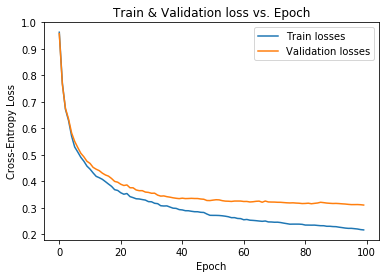

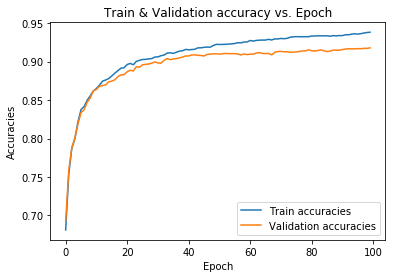

In [34]:
def partc():
  config = default_config_part_c()
  report = evaluate_model(config)
  train_report = report['train_report']
  plot_from_train_report(train_report)
partc()

In [ ]:
def partreg():
  config = custom_config_from_part_c({
    'batch_size': 256,
    'learning_rate': 0.05,
    'L2_penalty': 0.1,
    'epochs': 120,
  })
  report = evaluate_model(config)
  train_report = report['train_report']
  plot_from_train_report(train_report)
partreg()

------- Model Config: 
Activation: tanh 
N Epoches: 120 
N Batches: 195 
Batch size: 256 
Learning rate: 0.05 
L2 lambda: 0.1 
Momentum? True
Gamma: 0.9


Epoch: 0 loss train: 0.954910009460698 loss validate: 0.9467883058322721 Acc train: 0.6809 Acc validate: 0.6875
Epoch: 1 loss train: 0.7606069942486509 loss validate: 0.7545360102572986 Acc train: 0.7535 Acc validate: 0.7559
Epoch: 2 loss train: 0.667969412851394 loss validate: 0.670527958330118 Acc train: 0.78666 Acc validate: 0.7846
Epoch: 3 loss train: 0.611606844414338 loss validate: 0.6174107310442014 Acc train: 0.80622 Acc validate: 0.8009
Epoch: 4 loss train: 0.5551356458528248 loss validate: 0.5619761531920014 Acc train: 0.82576 Acc validate: 0.8211
Epoch: 5 loss train: 0.5111757880136856 loss validate: 0.5174048474304729 Acc train: 0.83972 Acc validate: 0.8391
Epoch: 6 loss train: 0.4816973032493446 loss validate: 0.4887042772487681 Acc train: 0.85112 Acc validate: 0.8505
Epoch: 7 loss train: 0.45849697195331734 loss validate: 0.4683562471108339 Acc train: 0.8593 Acc validate: 0.8597
Epoch: 8 loss train: 0.43063475913268384 loss validate: 0.4496714768104709 Acc train: 0.86992 